_this notebook is meant to execute **`R`** in a `conda` environment_

# Introduction

This Notebook (the second-of-four) serves to introduce a user to a series of exercises focused on *higher order* **_Trend Surface analysis with R_**.

It consists of two sections:

<ol type = "1">
    <li>Trend analysis by Ordinary Least Squares</li>

    a) First-order trend surfaces
    b) Second-order trend surfaces

  <li>Trend Surface Prediction</li>
</ol>


<div class="alert alert-block alert-danger"><b>REQUIRED: </b></div>

**You are required to insert your outputs and any comment into this document.**

The document you submit should therefore contain the existing text in addition to:

> *   Plots and other outputs from executing the code chunks  
> *   Discussion of your plots and other outputs as well as conclusions reached.

This should also include any hypotheses and assumptions made as well as factors that may affect your conclusions.

## 1. Ordinary Least Square

From the previous [01_extraTrendSurface](https://github.com/AdrianKriger/APG3040C-APG4013C/blob/main/cptFlatsAquifer/01_extraTrendSurface.ipynb) Notebook we are aware our data suggests a trend surface; a water level as some smooth function of coordinates. A polynomial function of the coordinates.

The higher the degree of the polynomial (1st, 2nd, 3rd, etc.) the more the surface matches the original data. We should however take care.

We want realistic results and a prediction within our dataset. _**The higher the degree the more extreme the extrapolations.**_


_please install necessary packages through a `prompt` interface; as per the [requirements.txt](https://github.com/AdrianKriger/APG3040C-APG4013C/blob/main/cptFlatsAquifer/requirements.txt) Not here_.

In [ ]:
options(prompt="> ", continue="+ ", digits=3, width=70, show.signif.stars=T, repr.plot.width=8, repr.plot.height=8)
rm(list=ls())

# Install necessary packages: You only need to run this part once
##- install.packages(c("sf", "gstat", "ggplot2", "gridExtra","units", "terra","mgcv","fields","nlme"))

#library(repr)
library(sf) # 'simple features' representations of spatial objects
library(gstat) # geostatistics
#library(ggplot2) # Grammer of Graphics plots
#library(gridExtra) # arrange multiple ggplot graphics on one figure
library(units) # units of measure
library(terra) # gridded data structures ("rasters")
#library(geojsonio)
#library(mgcv) # for Generalized Additive Models
#library(fields) # NCAR etc. approach to surfaces
#library(nlme) # Linear and Nonlinear Mixed Effects Models#

In [ ]:
options(show.signif.stars=FALSE)

_**due to the limitation of the `lm` function (the `linear regression model`) in `R` we work with the UTM coordinates as a field in a `data.frame` and NOT spatial objects**. i.e.: we drop the units._

In [ ]:
file = 'cptFlatsAquifer_watertable4.txt'

In [ ]:
#-- import
cfaq <- read.csv(file, header = 1, sep = ',', dec = '.') #sep = '\t',
#- set crs
cfaq.sf <- st_as_sf(cfaq, coords=c("long", "lat"), crs = 4326) #wgs84
#- transform to local crs
cfaq.sf <- st_transform(cfaq.sf, crs = 32734) #utm 34s
cfaq$X <- st_coordinates(cfaq.sf)[, "X"]
cfaq$Y <- st_coordinates(cfaq.sf)[, "Y"]

In [ ]:
#-- look
head(cfaq ,3)

name,long,lat,waterLevel,elevation,depth,X,Y
EM_01,18.6,-34.1,14.4,20.4,63,274222,6227351
EM_27,18.6,-34.1,16.2,20.0,48,276191,6227571
EM_29,18.6,-34.1,18.8,25.5,39,279770,6229369


### a) First-order Trend Surface

When we talk about a first-degree trend surface we _literally mean_ the surface can be represented with a first degree polynomial; namely


$$
    Z = 𝜷_0 + 𝜷_1x + 𝜷_2y + ϵ
$$

where: $Z$ is the is the elevation of the surface at $(x,y)$; $𝜷$ are possible coefficients representing the average elevation and slopes in the $x$ and $y$ directions and $ε$ is the error term accounting for small fluctuations and deviations from the average.

A First-order trend surface defines a surface in terms of elevation and one other variable (e.g.: slope). In other words it is a plane surface.

Furthermore; _first-order_ referes to the **power** to which each coordinate is raised. Here its the first power.

In [ ]:
#- 1st order design matrix
#head(model.matrix(~st_coordinates(cfaq.sf)[,1] + st_coordinates(cfaq.sf)[,2], data=cfaq))
head(model.matrix(~X + Y, data=cfaq))

(Intercept),X,Y
1,274222,6227351
1,276191,6227571
1,279770,6229369
1,283452,6230352
1,282454,6231185
1,281858,6232089


We see the design matrix _[called X]_ is an _n_ * 3 matrix. With column 1 being an intercept, column 2 an x-value and column 3 a y-value.

Briefly and without getting into too much Math; if we apply the design matrix _[X]_ to the previous formula we get;

$$
    𝙮 = X𝜷 + ϵ
$$

This simplyfies our lives considerably; because we know $𝙮$ _---these are the elevations at known locations---_ and we know $X$. Our challenge now is to solve $𝜷$; which we can solve directly through;

$$
    𝜷_{sols} = (X^TX)^{-1}X^T . y
$$

**We _fit_ this linear model with the `lm` function.**

In [ ]:
# fit first order trend surface and summarize it goodness of fit
model.ts1 <- lm(waterLevel ~ X + Y, data=drop_units(cfaq))
summary(model.ts1)


Call:
lm(formula = waterLevel ~ X + Y, data = drop_units(cfaq))

Residuals:
   Min     1Q Median     3Q    Max 
-27.01  -8.46  -2.21   7.27  45.17 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept) -1.58e+04   3.87e+03   -4.08  0.00038
X            2.05e-03   6.09e-04    3.36  0.00240
Y            2.45e-03   6.14e-04    3.99  0.00049

Residual standard error: 16.4 on 26 degrees of freedom
Multiple R-squared:  0.464,	Adjusted R-squared:  0.423 
F-statistic: 11.3 on 2 and 26 DF,  p-value: 3e-04


In [ ]:
#model.ts1 <- lm(cfaq$waterLevel ~ st_coordinates(cfaq.sf)[,1] + st_coordinates(cfaq.sf)[,2])#, data=drop_units(cfaq))
#summary(model.ts1)

We see amoung the results of our **_fit_** is an Intercept ---an elevation--- and two coefficients that give a change in elevation per unit (in this case 500m).

In other words for every 500-m east and west we increase by 0.00205m and 0.00245m respectively.

<div class="alert alert-block alert-warning"><b>QUESTION: </b> </div>

- What is the equation of the trend surface? How does elevation vary
with the E and N coördinates? Is the relation statistically-significant?
How much of the total variability does it explain? Are all the coefficients
statistically-significant?

> [double click in this cell and type your answer here]

In [ ]:
#- summarize residuals (lack of fit)
res.ts1 <- set_units(residuals(model.ts1), m); summary(res.ts1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  -27.0    -8.5    -2.2     0.0     7.3    45.2 

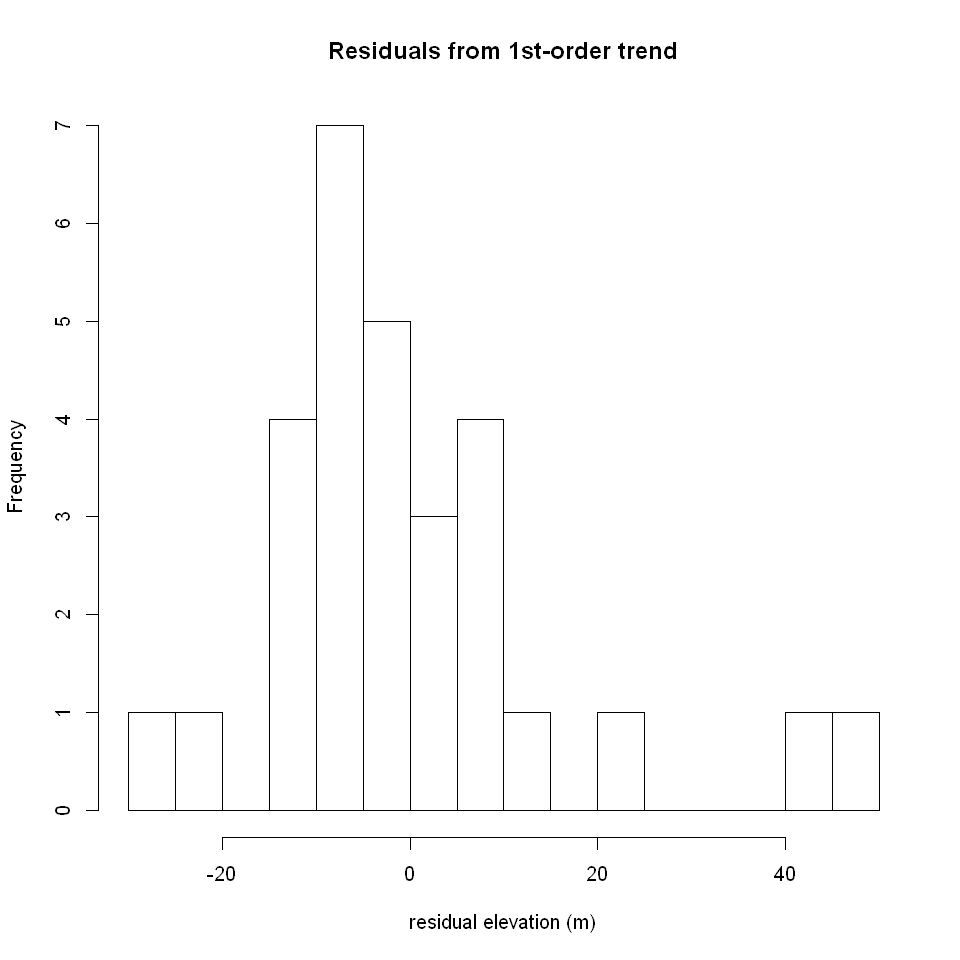

In [ ]:
#- histogram
hist(res.ts1, breaks=16, main="Residuals from 1st-order trend", xlab="residual elevation (m)")

In [ ]:
#rug(res.ts1)
range(res.ts1)

Units: [m]
[1] -27.0  45.2

In [ ]:
max(abs(res.ts1))/median(cfaq$waterLevel)*100

225 [m]

<div class="alert alert-block alert-warning"><b>QUESTION: </b> </div>

- What is the range of residuals? How does this compare with
the target variable? How are the residuals distributed in feature space?

> [double click in this cell and type your answer here]

**Two diagnostic `plot()`s of a `linear model` that deserve attention are:**

> a) residuals vs fitted values;  
> b) quantile-quantile ('QQ') plot of the standardized residuals. The QQ plot is significant and shows the standard residuals and the expected residuals (if the residuals were normally distributed) _---it should be a stright line_.

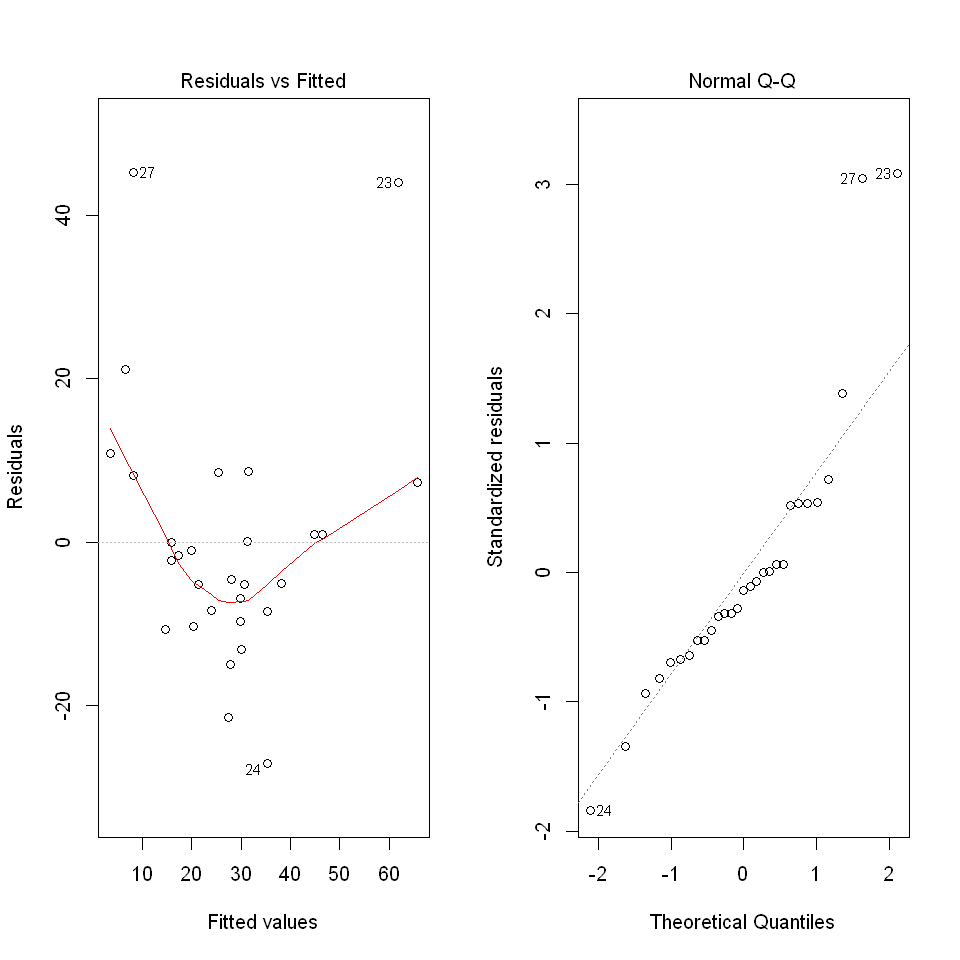

In [ ]:
#- diagnostic plot of linear model
par(mfrow=c(1,2))
plot(model.ts1, which=1:2)
par(mfrow=c(1,1))

<div class="alert alert-block alert-warning"><b>QUESTION: </b> </div>

- Does this model meet the feature-space requirements for a valid
linear model?

> a. No relation between the fitted values and the residuals  
> b. Equal spread of residuals across the range of fitted values  
> c. Normally-distributed standardized residuals

> [double click in this cell and type your answer here]

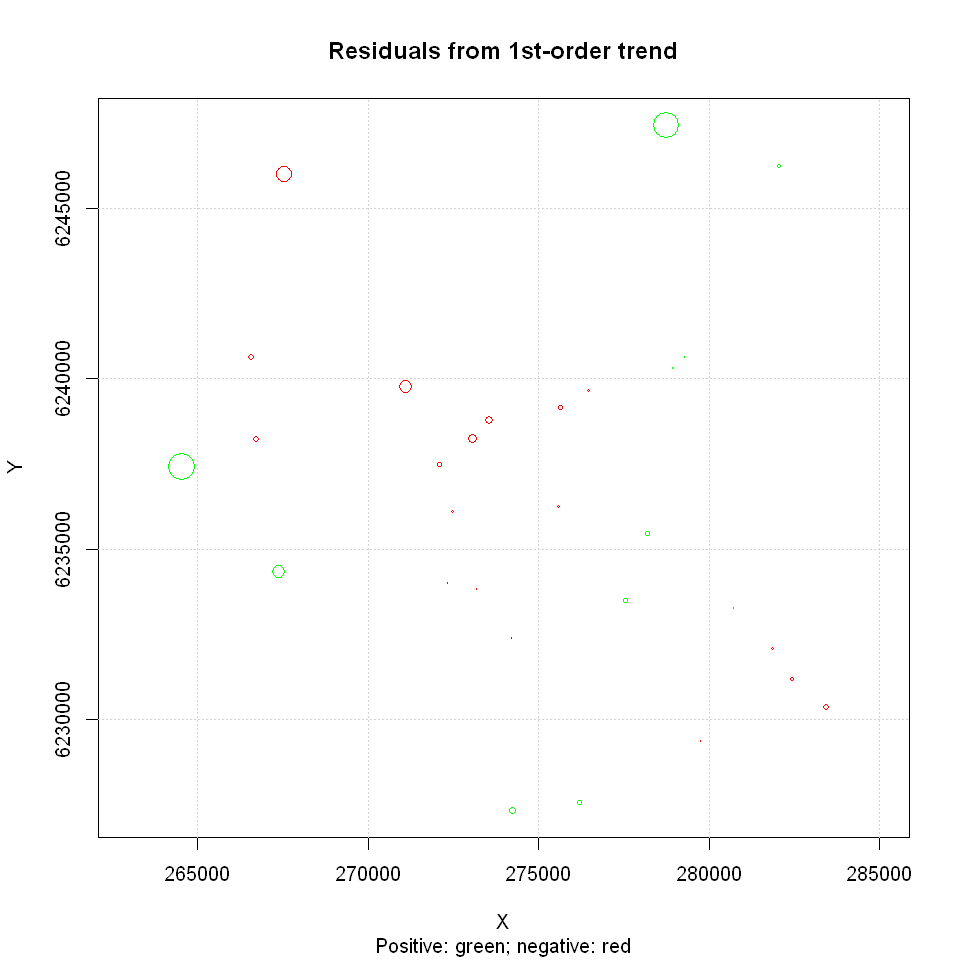

In [ ]:
#- residuals as postplot
plot(cfaq$Y ~ cfaq$X,
     #st_coordinates(cfaq.sf)[,1], st_coordinates(cfaq.sf)[,2],
     cex=3*abs(res.ts1)/max(abs(res.ts1)),
     col=ifelse(res.ts1 > set_units(0, m), "green", "red"),
     xlab="X", ylab="Y",
     main="Residuals from 1st-order trend",
     sub="Positive: green; Negative: red", asp=1)
grid()

<div class="alert alert-block alert-warning"><b>QUESTION: </b> </div>

- Is there a spatial pattern to the residuals? Is there local spatial
correlation without an overall pattern? What does this imply about the
suitability of a first-order trend surface?

> [double click in this cell and type your answer here]

### b) Second-order Trend Surface

Similarly; when we talk about a second-degree trend surface we _literally mean_ the surface can be represented with a second degree polynomial; namely

$$
    Z = 𝜷_0 + 𝜷_1x + 𝜷_2y + 𝜷_3x^2 + 𝜷_4y^2 + 𝜷_5(y^2*x^2) + ε
$$

where: $Z$ is the is the elevation of the surface at $(x,y)$; $𝜷$ are possible coefficients representing the average elevation, slopes and curvatures in the $x$ and $y$ directions and $ε$ is the error term accounting for small fluctuations and deviations from the average.

**Notice:** A Second-order trend surface includes linear, quadratice (squared) functions and their cross-product. This means the surface can be defined in terms of elevation, slope and another variable (e.g.: curvature). In other words it is no longer a plane surface.

**We also define and _fit_ the model matrix**

In [ ]:
#- 2nd order design matrix
head(model.matrix(~ X + Y + I(X^2) + I(Y^2) + I(X*Y), data=cfaq))

#head(model.matrix(~st_coordinates(cfaq.sf)[,1] + st_coordinates(cfaq.sf)[,2] + I(st_coordinates(cfaq.sf)[,1]^2) + I(st_coordinates(cfaq.sf)[,2]^2)
#  + I(st_coordinates(cfaq.sf)[,1]*st_coordinates(cfaq.sf)[,2]), data=cfaq))

(Intercept),X,Y,I(X^2),I(Y^2),I(X * Y)
1,274222,6227351,7.52e+10,3.88e+13,1.71e+12
1,276191,6227571,7.63e+10,3.88e+13,1.72e+12
1,279770,6229369,7.83e+10,3.88e+13,1.74e+12
1,283452,6230352,8.03e+10,3.88e+13,1.77e+12
1,282454,6231185,7.98e+10,3.88e+13,1.76e+12
1,281858,6232089,7.94e+10,3.88e+13,1.76e+12


In [ ]:
#- fit the 2nd order
model.ts2 <- lm(waterLevel ~ X + Y + I(X^2) + I(Y^2) + I(X*Y), data=drop_units(cfaq))

#model.ts2 <- lm(cfaq$waterLevel ~ st_coordinates(cfaq.sf)[,1] + st_coordinates(cfaq.sf)[,2] + I(st_coordinates(cfaq.sf)[,2]^2) + I(st_coordinates(cfaq.sf)[,1]^2) + I(st_coordinates(cfaq.sf)[,2]*st_coordinates(cfaq.sf)[,1]),
                #data=drop_units(cfaq))
summary(model.ts2)


Call:
lm(formula = waterLevel ~ X + Y + I(X^2) + I(Y^2) + I(X * Y), 
    data = drop_units(cfaq))

Residuals:
   Min     1Q Median     3Q    Max 
-26.21  -3.82  -1.55   2.41  29.56 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)  5.23e+06   2.79e+06    1.88  0.07350
X           -2.97e+00   6.38e-01   -4.66  0.00011
Y           -1.55e+00   8.94e-01   -1.73  0.09705
I(X^2)       2.51e-07   8.64e-08    2.90  0.00812
I(Y^2)       1.14e-07   7.17e-08    1.59  0.12550
I(X * Y)     4.55e-07   9.91e-08    4.59  0.00013

Residual standard error: 11.9 on 23 degrees of freedom
Multiple R-squared:  0.75,	Adjusted R-squared:  0.696 
F-statistic: 13.8 on 5 and 23 DF,  p-value: 2.71e-06


<div class="alert alert-block alert-warning"><b>QUESTIONS: </b> </div>

- How much of the variance does the second-order surface explain?

> [double click in this cell and type your answer here]

**Since we now have two linear models** _---one more complicated than the other---_ **we can compare them to determine if the simplier is in fact better. We do this with the `anova()` function**

In [ ]:
#- compare the 1st and 2nd order models statistically
anova(model.ts1, model.ts2)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
26,7001,NA,NA,NA,NA
23,3262,3,3739,8.79,0.000457


<div class="alert alert-block alert-warning"><b>QUESTIONS: </b> </div>

- Is the second-order surface statistically superior to the first-order
surface?

> [double click in this cell and type your answer here]

In [ ]:
#- summary
res.ts2 <- set_units(residuals(model.ts2), m)
summary(res.ts2)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -26.21   -3.82   -1.55    0.00    2.41   29.56 

1.47 [m]

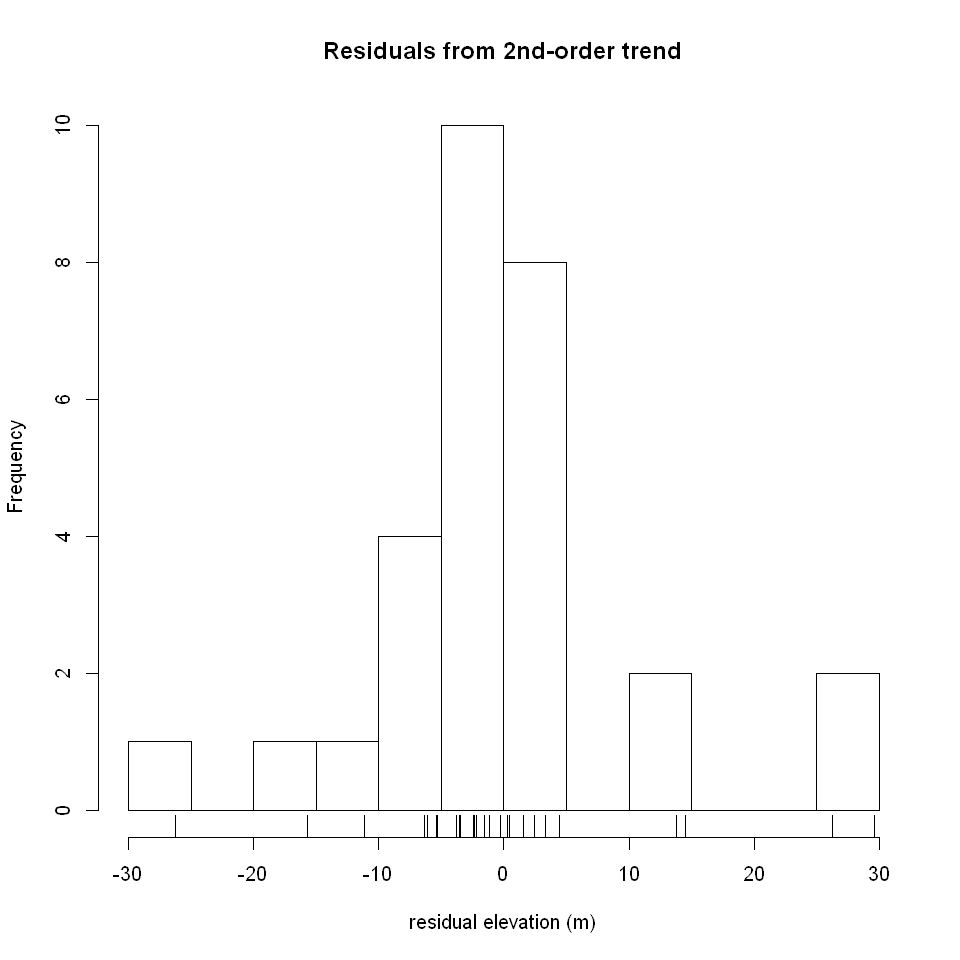

In [ ]:
#- graphic summary
hist(res.ts2, breaks=16, main="Residuals from 2nd-order trend", xlab="residual elevation (m)")
rug(res.ts2)
max(abs(res.ts2))/median(cfaq$waterLevel)

<div class="alert alert-block alert-warning"><b>QUESTIONS: </b> </div>

-  What is the range of residuals? How does this compare with the
target variable? How are they distributed in feature space? How do these
compare with the residuals from the first-order surface?

> [double click in this cell and type your answer here]

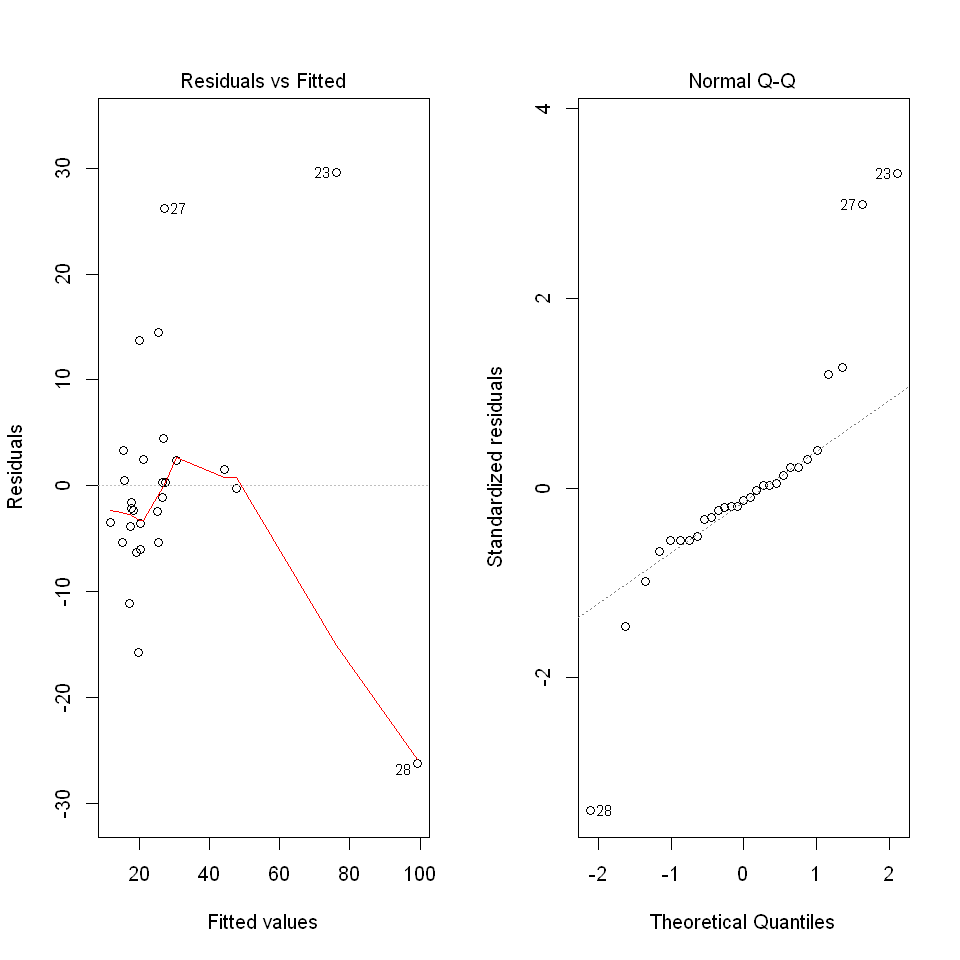

In [ ]:
#- diagnostic plots
par(mfrow=c(1,2))
plot(model.ts2, which=1:2)
par(mfrow=c(1,1))

<div class="alert alert-block alert-warning"><b>QUESTION: </b> </div>

- Does this model meet the feature-space requirements for a valid
linear model?

> a. No relation between the fitted values and the residuals  
> b. Equal spread of residuals across the range of fitted values  
> c. Normally-distributed standardized residuals

> [double click in this cell and type your answer here]

**Identify the largest overprediction that do not fit the normal Q-Q plot**

Looking at the QQ plot above we can take a value of 1 standard deviation to find the largest negative residuals.

In [ ]:
summary(sres.ts2 <- rstandard(model.ts2))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  -3.39   -0.51   -0.14   -0.01    0.21    3.31 

In [ ]:
(ix <- which(sres.ts2 < -1))

28 
28

In [ ]:
(cbind(actual=cfaq[ix, "waterLevel"], fitted=fitted(model.ts2)[ix],
       residual=res.ts2[ix],
       std.res <- sres.ts2[ix]))

,actual,fitted,residual,
28,73,99.2,-26.2,-3.39


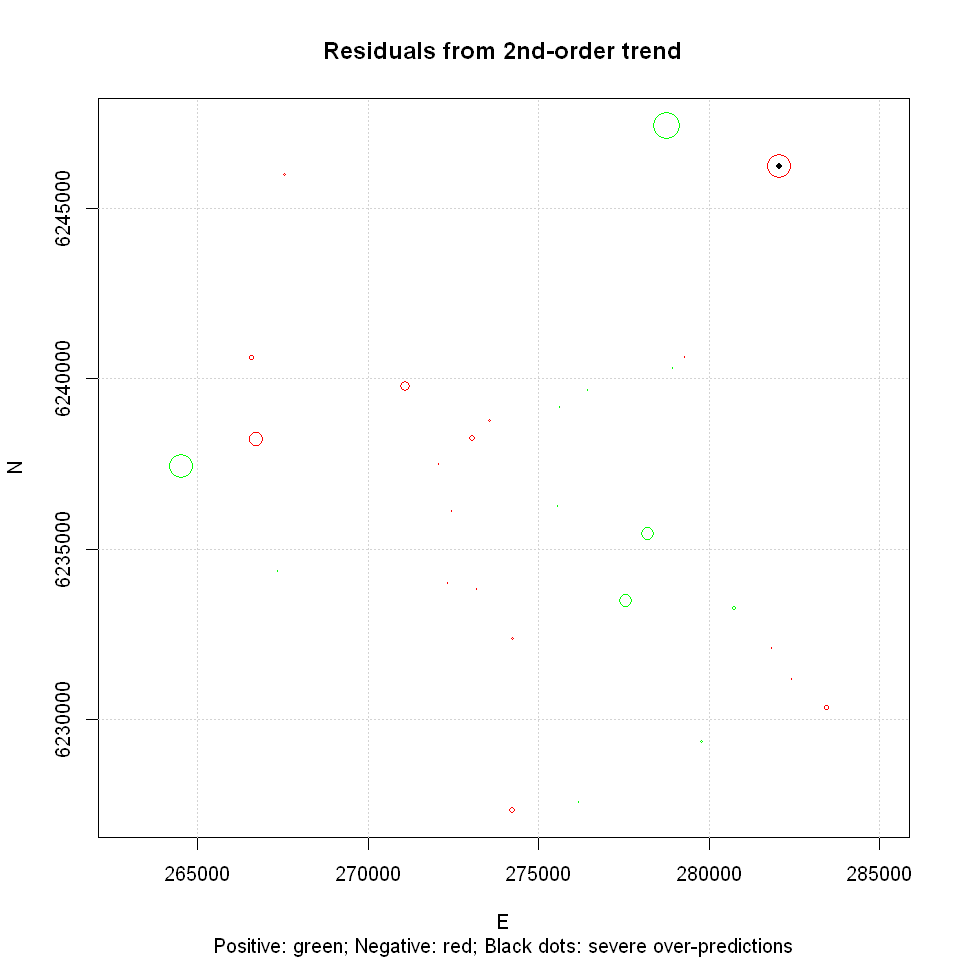

In [ ]:
#- display residuals as postplot and highlight the largest over-predictions
plot(cfaq$Y ~ cfaq$X,
     #st_coordinates(cfaq.sf)[,2] ~ st_coordinates(cfaq.sf)[,1],
     cex=3*abs(res.ts2)/max(abs(res.ts2)),
     col=ifelse(res.ts2 > set_units(0, m), "green", "red"),
     xlab="E", ylab="N", asp=1,
     main="Residuals from 2nd-order trend",
     sub="Positive: green; Negative: red; Black dots: severe over-predictions")
points(cfaq[ix, "Y"] ~ cfaq[ix, "X"],
       #st_coordinates(cfaq.sf)[ix, 'X'], st_coordinates(cfaq.sf)[ix , 'Y'],
       pch=20)
#plot(st_coordinates(cfaq.sf)[,2] ~ st_coordinates(cfaq.sf)[,1],pch=20, col="blue")#, add = TRUE)
text(cfaq[ix, "X"] ~ cfaq[ix, "Y"],
     #st_coordinates(cfaq.sf)[,1], st_coordinates(cfaq.sf)[,2],
     #st_coordinates(cfaq.sf)[ix, 'X'], st_coordinates(cfaq.sf)[ix ,'Y'],
     round(sres.ts2[ix], 2), pos=4)
grid()

<div class="alert alert-block alert-warning"><b>QUESTION: </b> </div>

-  Is there an overall pattern to the residuals? Is there local spatial
correlation without an overall pattern? Are the largest model residuals
clustered? Does there seem to be any anisotropy (stronger spatial dependence in one direction than the orthogonal direction)?

> [double click in this cell and type your answer here]

# 2. Trend Surface Prediction

**Now we come to the fun bit.**

**We use the** `trend surface model`, **we've just created, and predict values where non-exist over our study area. We typically do so on a regular grid**

**Since we've already covered creating a 500m grid with `Inverse Distance Weighting` from the previous [01_extraTrendSurface Notebook](https://github.com/AdrianKriger/APG3040C-APG4013C/blob/main/cptFlatsAquifer/01_extraTrendSurface.ipynb); we move through this part quickly**

In [ ]:
#(n.col <- length(seq.e <- seq(min.x <- floor(min(st_coordinates(cfaq.sf)[,2])/1000)*1000,
#                              max.x <- ceiling(max(st_coordinates(cfaq.sf)[,2])/1000)*1000, by=1000)))
#(n.row <- length(seq.n <- seq(min.y <- floor(min(st_coordinates(cfaq.sf)[,1])/1000)*1000,
#                              max.y <- ceiling(max(st_coordinates(cfaq.sf)[,1])/1000)*1000, by=1000)))

n.col <- length(seq.e <- seq(min.x <- floor(min(cfaq$X)/1000)*1000,
                              max.x <- ceiling(max(cfaq$X)/1000)*1000, by=1000))

n.row <- length(seq.n <- seq(min.y <- floor(min(cfaq$Y)/1000)*1000,
                              max.y <- ceiling(max(cfaq$Y)/1000)*1000, by=1000))


#we want a 2km grid
grid <- rast(nrows = n.row, ncols = n.col,
                xmin=min.x, xmax=max.x,
                ymin=min.y, ymax=max.y, crs = st_crs(cfaq.sf)$proj4string,
                resolution = 500, names="waterLevel")

values(grid) <- NA_real_

#class(grid)
#crs(grid)
#plot(grid); grid()

grid.df <- as.data.frame(grid, xy = TRUE, na.rm = FALSE)
names(grid.df)[1:2] <- c("X", "Y") # match the names of the point dataset
summary(grid.df)

       X                Y             waterLevel  
 Min.   :264250   Min.   :6227250   Min.   : NA   
 1st Qu.:269125   1st Qu.:6232250   1st Qu.: NA   
 Median :274000   Median :6237500   Median : NA   
 Mean   :274000   Mean   :6237500   Mean   :NaN   
 3rd Qu.:278875   3rd Qu.:6242750   3rd Qu.: NA   
 Max.   :283750   Max.   :6247750   Max.   : NA   
                                    NA's   :1680  

**Now we are ready. We map the values of the `second-order trend surface` onto this *empty* grid**

We do this at a Best fit and a 95% prediction level

In [ ]:
pred.ts2 <- predict.lm(model.ts2,
                       newdata = grid.df,
                       interval = "prediction", level = 0.95)

summary(pred.ts2)

In [ ]:
summary(values(grid))

**And add the `model predictions` to the surface**

In [ ]:
values(grid) <- pred.ts2[,"fit"]
summary(values(grid))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    4.9    17.8    24.4    32.5    40.7   127.9 

   waterLevel   
 Min.   :  4.9  
 1st Qu.: 17.8  
 Median : 24.4  
 Mean   : 32.5  
 3rd Qu.: 40.7  
 Max.   :127.9  

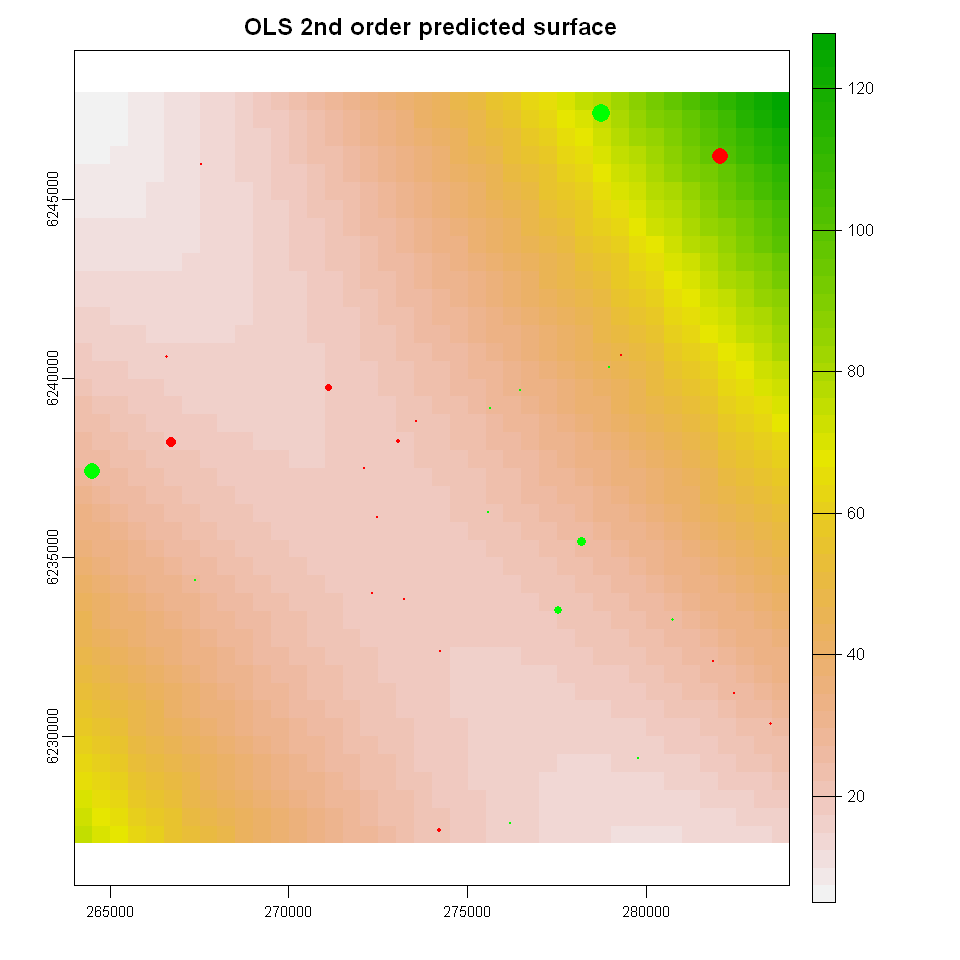

In [ ]:
#-- plot
plot(grid, main = "OLS 2nd order predicted surface")
points(st_coordinates(cfaq.sf)[,2] ~ st_coordinates(cfaq.sf)[,1], pch=16,
       col = ifelse(res.ts2 < set_units(0, m), "red", "green"),
       cex=2*abs(res.ts2)/max(abs(res.ts2)))

The `plot()` illustrates the residuals at each point _[red < and green >]_ with the size proportinal to the error.

<div class="alert alert-block alert-warning"><b>QUESTION: </b> </div>

-  How well does the trend surface fit the points? Are there obvious problems??

> [double click in this cell and type your answer here]

In [ ]:
#-- the following three cells are general housekeeping to add the (best, lwr and upr) predictions to the data.frame

summary(pred.ts2)

      fit             lwr             upr       
 Min.   :  4.9   Min.   :-35.0   Min.   : 40.7  
 1st Qu.: 17.8   1st Qu.: -8.4   1st Qu.: 44.4  
 Median : 24.4   Median : -2.8   Median : 51.8  
 Mean   : 32.5   Mean   :  4.1   Mean   : 60.8  
 3rd Qu.: 40.7   3rd Qu.: 11.2   3rd Qu.: 69.8  
 Max.   :127.9   Max.   : 91.3   Max.   :164.4  

In [ ]:
summary(grid.df)

       X                Y             waterLevel  
 Min.   :264250   Min.   :6227250   Min.   : NA   
 1st Qu.:269125   1st Qu.:6232250   1st Qu.: NA   
 Median :274000   Median :6237500   Median : NA   
 Mean   :274000   Mean   :6237500   Mean   :NaN   
 3rd Qu.:278875   3rd Qu.:6242750   3rd Qu.: NA   
 Max.   :283750   Max.   :6247750   Max.   : NA   
                                    NA's   :1680  

In [ ]:
grid.df[, 3:5] <- pred.ts2
names(grid.df)[3:5] <- c("ts2.fit", "ts2.lwr", "ts2.upr")
summary(grid.df)

       X                Y              ts2.fit         ts2.lwr     
 Min.   :264250   Min.   :6227250   Min.   :  4.9   Min.   :-35.0  
 1st Qu.:269125   1st Qu.:6232250   1st Qu.: 17.8   1st Qu.: -8.4  
 Median :274000   Median :6237500   Median : 24.4   Median : -2.8  
 Mean   :274000   Mean   :6237500   Mean   : 32.5   Mean   :  4.1  
 3rd Qu.:278875   3rd Qu.:6242750   3rd Qu.: 40.7   3rd Qu.: 11.2  
 Max.   :283750   Max.   :6247750   Max.   :127.9   Max.   : 91.3  
    ts2.upr     
 Min.   : 40.7  
 1st Qu.: 44.4  
 Median : 51.8  
 Mean   : 60.8  
 3rd Qu.: 69.8  
 Max.   :164.4  

**We end this Notebook with summarizing the uncertainty from the trend surface as absolute differences between the upper and lower predictions limits; and then a percentage of the best fit value. And then illustrate this 95% prediction interval as a it applies to our study area**

In [ ]:
#-- uncertainty as upper and lower absolute values
summary(grid.df$ts2.diff.range <- grid.df$ts2.upr - grid.df$ts2.lwr)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   51.0    52.0    54.7    56.7    59.1    93.9 

In [ ]:
#- uncertainty as percentage of best fit
summary(100*grid.df$ts2.diff.range/grid.df$ts2.fit)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     57     145     223     242     293    1628 

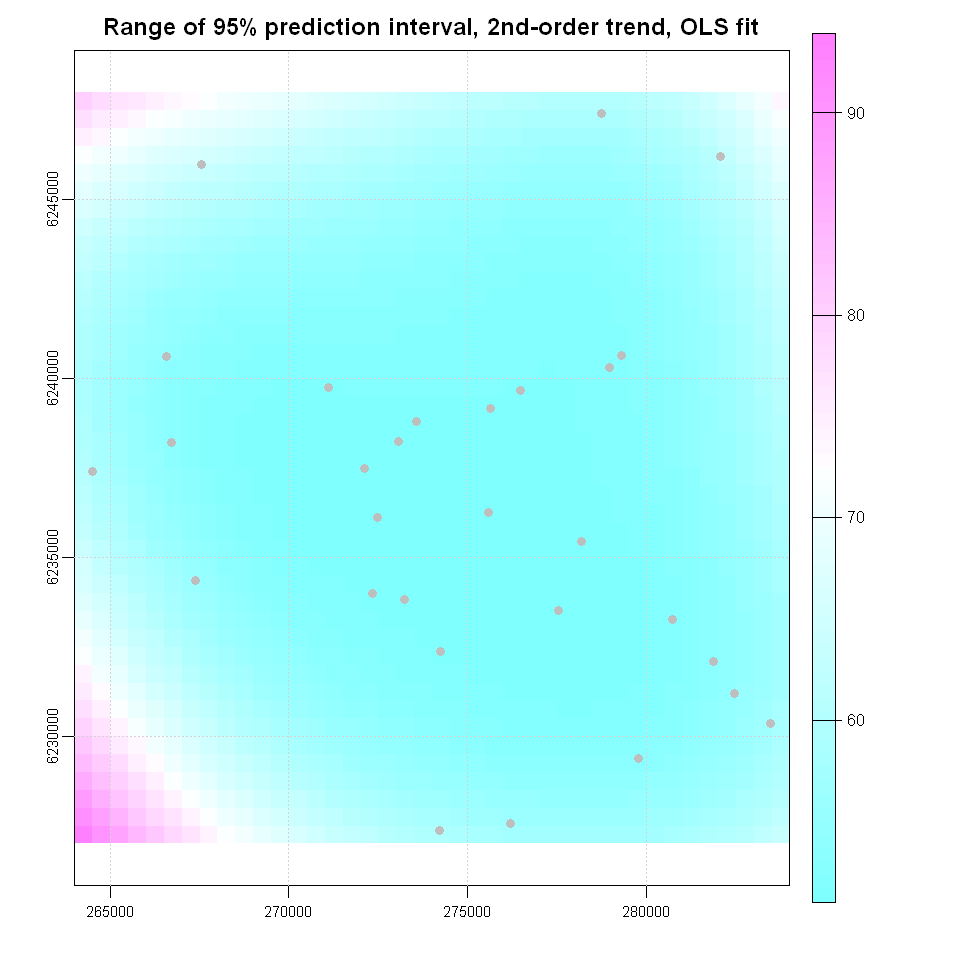

In [ ]:
grid.diff <- grid
values(grid.diff) <- grid.df$ts2.diff.range
plot(grid.diff, col=cm.colors(64),
main="Range of 95% prediction interval, 2nd-order trend, OLS fit")
grid()
points(st_coordinates(cfaq.sf)[,2] ~ st_coordinates(cfaq.sf)[,1], pch=16,col = "gray")

<div class="alert alert-block alert-warning"><b>QUESTION: </b> </div>

-  What are the units of prediction interval? How large are they?
How does this compare to the variable we are trying to predict?

> [double click in this cell and type your answer here]

- Describe the spatial pattern of the prediction interval.

> [double click in this cell and type your answer here]

<div class="alert alert-block alert-danger"><b>stop here! </b></div>